# Convolutionnal Neural Network (CNN)

This notebook implements a CNN that classifies preprocessed tweets in two categories.

In [ ]:
import math

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import f1_score

### Data loading

In this part, **we assume you have already downloaded the preprocessed data** ([link](TODO)) and placed it under `input/cnn/` or have gone through the (rather long to execute) preprocessing pipeline described in `input/README.md` and `preprocessing.ipynb`. 

We define two `torch.dataloader`, one for the training set and one for the testing set. The two loaders will always be asked a batch size of 1, since we want to load one block at a time (1 bloc $\approx$ 110k entries for the training set).

This way of loading data has been choosen to have a more fine-grained control on memory usage, since loading all the tweets at one time would eat all the memory (for a reminder, each block is of shape `(110k, 3, 50, 20)` after the preprocessing).

In [ ]:
class TrainTweetDataset(Dataset):
    def __init__(
        self, n_blocs, data_dir, device, transform=None, target_transform=None
    ):
        self.n_blocs = n_blocs
        self.device = device
        self.labels = {
            idx: torch.load(data_dir + f"y_train_cnn_new_{idx}_full.pt", self.device)
            for idx in range(n_blocs)
        }
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_blocs

    def __getitem__(self, idx):
        train_data = torch.load(
            self.data_dir + f"X_train_cnn_new_{idx}_full_3CH.pt", self.device
        )
        # train_data = train_data.view(train_data.shape[0], 3, 50, 20)
        labels = self.labels[idx]
        if self.transform:
            train_data = self.transform(train_data)
        if self.target_transform:
            labels = self.target_transform(labels)
        return train_data, labels


class TestTweetDataset(Dataset):
    def __init__(
        self, n_blocs, data_dir, device, transform=None, target_transform=None
    ):
        self.device = device
        self.n_blocs = n_blocs
        self.labels = {
            idx: torch.load(data_dir + f"y_test_cnn_new_{idx}_full.pt", self.device)
            for idx in range(n_blocs)
        }
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_blocs

    def __getitem__(self, idx):
        test_data = torch.load(
            self.data_dir + f"X_test_cnn_new_{idx}_full_3CH.pt", self.device
        )
        # test_data = test_data.view(test_data.shape[0], 3, 50, 20)
        labels = self.labels[idx]
        if self.transform:
            test_data = self.transform(test_data)
        if self.target_transform:
            labels = self.target_transform(labels)
        return test_data, labels

In [ ]:
# =============================== CONSTANTS ===============================
# Main directory path
PREFIX = "/content/drive/MyDrive/Colab Notebooks/batches/small/"
# Number of blocs of data
N_BLOCS = 15
# Number of features, equivalent to the embedding size
N_FEATURES = 20
# Number of channels, equivalent to the number of different embedding used
N_CHANNELS = 3
# Truncated length of tweets
LEN_TWEET = 50
# =========================================================================

In [ ]:
def device_type():
    if torch.cuda.is_available():
        return "cuda:0"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"


device = torch.device(device_type())
print(f"device={device}")

device=cuda:0


### Model architecture definition

We defined a model containing two convolutionnal layers, and two fully connected layers with dropout. The fully connected phase does the classification work, while the convolutionnal one aims at extracting features from our preprocessed data.

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        hidden_size1,
        hidden_size2,
        kernel_size,
        output_size,
        dropout=None,
    ):
        super(CNN, self).__init__()
        stride = N_FEATURES

        # ==== CONVOLUTION 1 ====
        self.conv1 = nn.Conv1d(
            in_channels=input_size[0],
            out_channels=hidden_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
        )
        self.conv1d_kernel_size = 2
        output1 = (input_size[1] - kernel_size + 1) / (stride) + 1
        
        self.relu1 = nn.ReLU()

        self.pool_kernel_size = 3
        self.pool_stride = 1
        self.pool1 = nn.MaxPool1d(
            kernel_size=self.pool_kernel_size, stride=self.pool_stride
        )
        output2 = (output1 - self.pool_kernel_size + 1) / 1


        # ==== CONVOLUTION 2 ====
        self.conv2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size1,
            kernel_size=self.conv1d_kernel_size,
            stride=1,
            padding=1,
        )
        self.pool2_kernel_size = 2
        output3 = (output2 - self.conv1d_kernel_size + 2 * 1) / 1 + 1
        
        self.relu2 = nn.ReLU()
        
        self.pool2 = nn.MaxPool1d(
            kernel_size=self.pool2_kernel_size, stride=self.pool_stride
        )
        self.output4 = math.floor(
            (output3 - self.pool2_kernel_size + 1) / self.pool_stride
        )
        
        # ==== FULLY CONNECTED LAYER 1 ====
        self.fc1 = nn.Linear(hidden_size1 * self.output4, hidden_size2)
        self.relu3 = nn.ReLU()

        # ==== FULLY CONNECTED LAYER 2 ====
        self.fc2 = nn.Linear(hidden_size2, output_size)

        # Optional dropout layer
        self.dropout = torch.nn.Dropout(dropout) if dropout else None
        
    def forward(self, x):
        x = x.view(x.shape[0], N_CHANNELS, -1)
        
        # Convolution phase
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)

        # Fully connected phase
        x = self.fc1(x)
        x = self.relu3(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.fc2(x)

        x = x.flatten()
        return x

In [ ]:
train_ds = TrainTweetDataset(N_BLOCS, PREFIX, device)
test_ds = TestTweetDataset(N_BLOCS, PREFIX, device)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

### Train the model

We can now proceed to train our model on the training blocks. All blocks are fed to the model for each epoch.

In [ ]:
%%time
def get_preds(output):
    sigmoid_outputs = torch.sigmoid(output)
    pred = torch.zeros(output.shape, device=output.device)
    pred[sigmoid_outputs < 0.5] = 0
    pred[sigmoid_outputs >= 0.5] = 1
    return pred

def run_epoch(model, X, y, optimizer, scheduler, criterion, batch_size):
    loss_history = []
    accuracy_history = []
    lr_history = []
    model.train()

    permutation = torch.randperm(X.size()[0])
    print(permutation)
    print(f"batch_size={batch_size}")

    # ==================================================
    y[y == -1] = 0  # FOR BCE LOSS, we need {0,1} labels

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        # Zero the gradients
        optimizer.zero_grad()
        # Compute model output
        output = model(batch_x)
        # Compute loss
        loss = criterion(output, batch_y)
        # Backpropagate loss
        loss.backward()
        # Perform an optimizer step
        optimizer.step()
        # Perform a learning rate scheduler step
        scheduler.step()

        loss_float = loss.item()

        pred = get_preds(output)
        correct = pred.eq(batch_y).sum().item()
        accuracy_float = correct / len(batch_x)

        loss_history.append(loss_float)
        accuracy_history.append(accuracy_float)
        lr_history.append(scheduler.get_last_lr()[0])
        if i % (X_train.shape[0] // batch_size // 10) == 0:
            print(
                f"Tweet {i} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


# MODEL DEFINITION
input_channels = N_CHANNELS
nb_features = N_FEATURES
len_tweet = LEN_TWEET

dropout = 0.25
hidden_size = 64
hidden_size1 = 32
hidden_size2 = 16
kernel_size = nb_features*3
output_size = 1

model = CNN(input_size=(input_channels,len_tweet*nb_features),
            hidden_size=hidden_size,
            hidden_size1=hidden_size1,
            hidden_size2=hidden_size2,
            kernel_size=kernel_size,
            output_size=output_size,
            dropout=dropout)

model = model.to(device)
#raise Exception("test")
l = torch.nn.BCEWithLogitsLoss()
epochs = 3
learning_rate = 1e-3
weight_decay = 1e-5
BATCH_SIZE = 2048
loader = iter(train_dataloader)

optimizer = torch.optim.AdamW(model.parameters(), **dict(
    lr=learning_rate,
    weight_decay=weight_decay,
))
criterion = torch.nn.functional.cross_entropy
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_dataloader.dataset) * epochs) // train_dataloader.batch_size,
)
loss_history = []
accuracy_history = []
lr_history = []
bloc_limit = -1  # -1 for no limit (= all 15 blocs)
for epoch in range(1, epochs+1):
    for bloc_idx, (X_train, y_train) in enumerate(train_dataloader):
        print(f"bloc_idx={bloc_idx}")
        X_train = X_train.squeeze()
        X_train = X_train.flatten(2)
        y_train = y_train.squeeze()
        print(f"X.shape={X_train.shape}\ny.shape={y_train.shape}")

        loss_h, acc_h, lr_h = run_epoch(model,
                                        X_train,
                                        y_train,
                                        optimizer,
                                        scheduler=scheduler,
                                        criterion=l,
                                        batch_size=BATCH_SIZE,)
        print(f"Average bloc loss: {np.mean(loss_h)}\nAverage bloc accuracy: {np.mean(acc_h)}")
        loss_history.extend(loss_h)
        accuracy_history.extend(acc_h)
        lr_history.extend(lr_h)

        print(f"DONE bloc_idx={bloc_idx}")

        if bloc_idx == bloc_limit:
            break

    print(f"DONE epoch={epoch}")

training_n_epochs = epoch
training_n_blocs = bloc_idx+1

output1 after conv1 48.05
output2 after pool1 46.05
output3, after conv2 47.05
output4 after pool2 =  46
bloc_idx=0
X.shape=torch.Size([116659, 3, 1000])
y.shape=torch.Size([116659])
tensor([115388,  19013, 101574,  ...,  45379,  92328,  46124])
batch_size=2048
Tweet 0 batch_loss=6.94e-01 batch_acc=0.503 lr=9.988e-04 
Tweet 10240 batch_loss=6.17e-01 batch_acc=0.648 lr=9.568e-04 
Tweet 20480 batch_loss=5.74e-01 batch_acc=0.677 lr=8.597e-04 
Tweet 30720 batch_loss=5.38e-01 batch_acc=0.715 lr=7.192e-04 
Tweet 40960 batch_loss=5.15e-01 batch_acc=0.726 lr=5.523e-04 
Tweet 51200 batch_loss=5.14e-01 batch_acc=0.722 lr=3.790e-04 
Tweet 61440 batch_loss=4.95e-01 batch_acc=0.734 lr=2.204e-04 
Tweet 71680 batch_loss=5.12e-01 batch_acc=0.728 lr=9.549e-05 
Tweet 81920 batch_loss=5.03e-01 batch_acc=0.728 lr=1.937e-05 
Tweet 92160 batch_loss=4.90e-01 batch_acc=0.757 lr=1.218e-06 
Tweet 102400 batch_loss=5.08e-01 batch_acc=0.730 lr=4.323e-05 
Tweet 112640 batch_loss=4.89e-01 batch_acc=0.751 lr=1.403e-

#### Visualize the training results

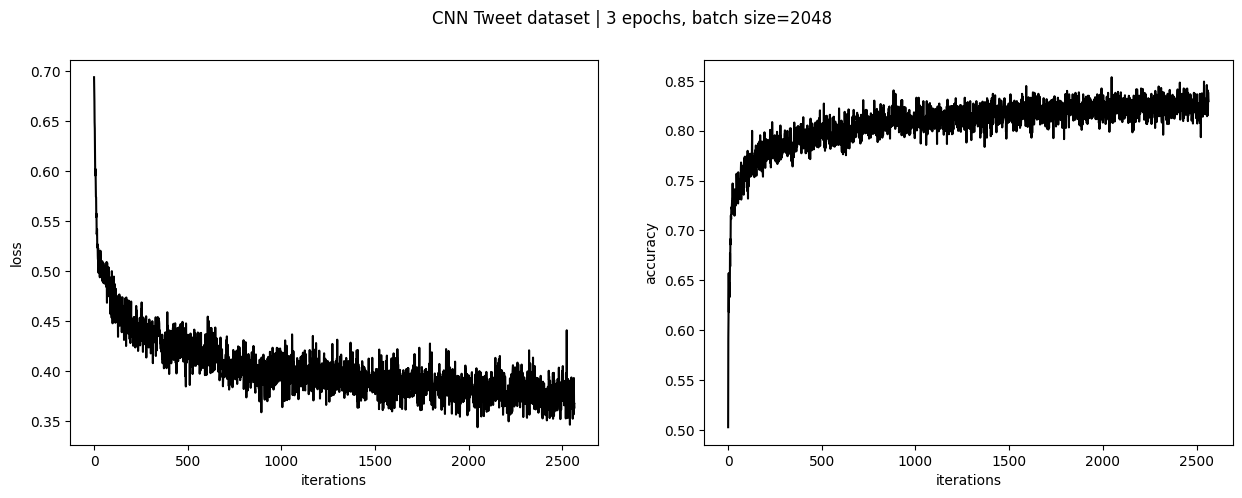

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
f.set_size_inches(15,5)
f.suptitle(f"CNN Tweet dataset | {training_n_epochs} epochs, batch size={BATCH_SIZE}")
ax1.set_xlabel("iterations")
ax1.set_ylabel("loss")
ax1.plot(np.arange(len(loss_history)), loss_history, c='k')
ax2.set_xlabel("iterations")
ax2.set_ylabel("accuracy")
ax2.plot(np.arange(len(accuracy_history)), accuracy_history, c='k')
plt.savefig("loss_accuracy_training.png")

### Feed the validation set to the trained model

In this phase, we feed all the testing blocks to the trained model and compute two metrics : the accuracy and the F1-score.

In [ ]:
def validate(model, X_test, y_test, criterion):
    N = y_test.shape[0]
    model.eval()
    y_test[y_test == -1] = 0  # FOR BCE LOSS, we need {0,1} labels
    output = model(X_test)
    test_loss = criterion(output.cpu(), y_test.cpu()).item()

    pred = get_preds(output)
    correct = pred.eq(y_test).sum().item()
    f1 = f1_score(y_test.cpu(), pred.cpu(), average='binary')
    test_loss /= N

    print(
        "Test set: Loss: {:.8f}, Accuracy: {}/{} ({:.0f}%), F1: {}".format(
            test_loss,
            correct,
            N,
            100.0 * correct / N,
            f1
        )
    )
    return test_loss, correct / N, f1

test_loss_history = []
test_accuracy_history = []
f1s = []
for bloc_idx, (X_test, y_test) in enumerate(test_dataloader):
        print(f"bloc_idx={bloc_idx}")
        X_test = X_test.squeeze()
        X_test = X_test.flatten(2)
        y_test = y_test.squeeze()
        print(f"X.shape={X_test.shape}\ny.shape={y_test.shape}")

        loss, acc, f1 = validate(model, X_test, y_test, criterion=l)
        test_loss_history.append(loss)
        test_accuracy_history.append(acc)
        f1s.append(f1)

        # del X_train, y_train
        print(f"DONE bloc_idx={bloc_idx}")

bloc_idx=0
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000737, Accuracy: 41398/49997 (83%), F1: 0.8332913282022449
DONE bloc_idx=0
bloc_idx=1
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000741, Accuracy: 41314/49997 (83%), F1: 0.8314471513151508
DONE bloc_idx=1
bloc_idx=2
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000730, Accuracy: 41333/49997 (83%), F1: 0.8328123190922775
DONE bloc_idx=2
bloc_idx=3
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000738, Accuracy: 41349/49997 (83%), F1: 0.8327596209630633
DONE bloc_idx=3
bloc_idx=4
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000739, Accuracy: 41307/49997 (83%), F1: 0.8319603975712573
DONE bloc_idx=4
bloc_idx=5
X.shape=torch.Size([49997, 3, 1000])
y.shape=torch.Size([49997])
Test set: Loss: 0.00000731, Accuracy: 41506/49997 (83%), F1: 0.8

We notice a F1-score of around 82-83%, which was the best we could get so far.

## Prediction on the real dataset

We load the `X_T_3CH.pt` file which contains the unlabeled preprocessed tweets we need to predict. Again, please refer to the top of this notebook to download the preprocessed files if needed.

We finally save the predictions along a parameters file which contains our model settings.

In [ ]:
X_T = torch.load(PREFIX+"X_T_3CH.pt", device)

In [ ]:
PREDICTION_FILENAME = PREFIX+"submissions/predictions_cnn_alldata_2048_15blocs_BCE.csv"

def make_predictions(X_T, model, filename):
    if os.path.exists(filename):
        raise Exception(f"{filename} already exist, comment this line or provide a new filename")
    model.eval()
    with torch.no_grad():
        outputs = model(X_T)
        preds = get_preds(outputs).cpu()
        print("preds", {preds})
    df = pd.DataFrame({"Id": np.arange(1, preds.shape[0]+1), "Prediction": preds})
    df["Prediction"] = df["Prediction"].map({0: -1, 1: 1})  # roll back to {-1,1} labels
    df["Prediction"] = df["Prediction"].astype(int)
    print(df)
    print(df["Prediction"].value_counts())
    print(f"Saving to {filename}...")
    df.to_csv(filename, index=False)
    with open(filename.replace(".csv", "_params.txt"), 'w+') as f:
        params = [
            f"filename={filename}",
            f"== TRAINING STATS ==",
            f"number of epochs done = {training_n_epochs}",
            f"number of blocs processed per epoch = {training_n_blocs}",
            f"= loss stats =",
            f"final loss at end of training = {loss_history[-1]}",
            f"best loss on all training = {min(np.abs(loss_history))}",
            f"= accuracy stats =",
            f"final accuracy at end of training = {accuracy_history[-1]}",
            f"best accuracy on all training = {max(accuracy_history)}",
            f"best f1 score on validation set = {max(f1s)}",
            f"== PARAMS ==",
            f"N_FEATURES = {N_FEATURES}",
            f"BATCH_SIZE = {BATCH_SIZE}",
            f"epochs = {epochs}",
            f"loss type = {l}",
            f"dropout = {dropout}",
            f"hidden_size = {hidden_size}",
            f"hidden_size1 = {hidden_size1}",
            f"hidden_size2 = {hidden_size2}",
            f"kernel_size = {kernel_size}",
            f"output_size = {output_size}",
            "OPTIMIZER PARAMS",
            f"learning_rate = {learning_rate}",
            f"weight_decay = {weight_decay}",
        ]
        f.writelines("\n".join(params))

        return df

df = make_predictions(X_T, model, PREDICTION_FILENAME)


Exception: ignored

### Visualize some predictions

We now print some of the predicted data in order to visualize the non-preprocessed tweets (text form) along with the labels associated.

In [ ]:
TRUE_TWEETS = "twitter-datasets/test_data.txt"

testing_tweets = []
testing_tweets_ids = []
with open(TRUE_TWEETS, "r") as f:
    for line in f:
        parsed_line = line.rstrip().split(',')
        tweet = ','.join(parsed_line[1:]).split()
        testing_tweets.append(' '.join(tweet))
        testing_tweets_ids.append(int(parsed_line[0]))

df["tweet"] = testing_tweets
df["Smiley"] = df["Prediction"].map({-1: ":(", 1: ":)"})
pd.set_option('display.max_colwidth', None)
df[["tweet", "Smiley"]].sample(10)

,tweet,Smiley
4920,dat was a lunch brake date,:)
2889,"black oxide alloy steel set screw , hex socket drive , cone point , #8-32 , 5/16 "" length ( pack of 50 set screws ar ... <url>",:(
4575,pissed off is a understatement,:(
9594,"<user> <user> 28th of january is too vuage a date to remember , il always remember the valentines day massacre",:)
6606,waiting for <user> to finish her vc ...,:)
6418,my booo ; * the only one who understands me <url>,:)
4134,"20x33 custom picture frame / poster frame 2.375 "" wide complete brazilian walnut frame ( 50036 this frame is man ... <url>",:(
9269,"work with me people ! ( 1 "" work with me people "" is a book about improving the work environment one person at a t ... <url>",:(
3911,<user> that awkward moment when i don't remember anything about pottermore ... sorry !,:(
6291,<user> hopefully xxx,:)
